<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_7_ML4HS_UC2023_Integrated_gradients_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[SLIDE](https://jamboard.google.com/d/1MAaDvaBTjy3RluS62r8mXKiOI6ZWDKc8Mn7BZap62eA/edit?usp=sharing)
[PAPER IG](https://arxiv.org/pdf/1703.01365.pdf)

In [ ]:
#Build a dummy dataset
import numpy as np

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate the toy dataset
num_samples = 100000
num_variables = 10
num_correlated_variables = 5

# Generate the correlated variables
correlated_variables = 2*(2*np.random.rand(num_samples, num_correlated_variables)-1)

# Generate the uncorrelated variables
uncorrelated_variables = 2*np.random.rand(num_samples, num_variables - num_correlated_variables)-1

# Concatenate the variables
X = np.concatenate((correlated_variables, uncorrelated_variables), axis=1)

# Generate the target classes based on a linear relationship with the correlated variables
weights = np.array([0.2,-0.2,0.2,-0.3,0.3])
bias = 0.0*np.random.randn()
logits = np.dot(correlated_variables, weights) + bias
probabilities = 1 / (1 + np.exp(-logits))
y = np.random.binomial(1, probabilities)

if 0:
  X[y==1,6]+=0.1*np.random.rand(num_samples)

Text(0, 0.5, 'data 4')

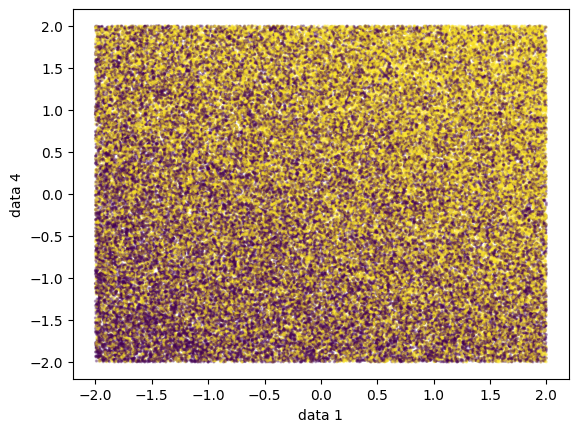

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:,0],X[:,4],c=y,s=2,alpha =0.3)
plt.xlabel("data 1")
plt.ylabel("data 4")

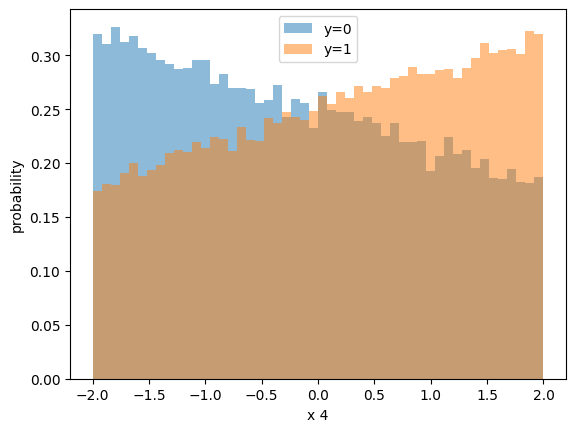

In [ ]:
plt.figure()
plt.hist(X[y==0,4],50,alpha =0.5,density=True,label="y=0")
plt.hist(X[y==1,4],50,alpha =0.5,density=True,label="y=1")
plt.xlabel("x 4")
plt.ylabel("probability")
plt.legend()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Instantiate the logistic regression model
input_size = X.shape[1]
model = LogisticRegression(input_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

losses = []
accuracies = []


# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    predicted_labels = (outputs >= 0.5).float().squeeze()
    accuracy = (predicted_labels == y_tensor).float().mean()

    # Append results to lists
    losses.append(loss.item())
    accuracies.append(accuracy.item())

    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Print the model's parameters
print("Model parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


Epoch [20/150], Loss: 0.6762226223945618
Epoch [40/150], Loss: 0.6577348113059998
Epoch [60/150], Loss: 0.6519841551780701
Epoch [80/150], Loss: 0.6499184966087341
Epoch [100/150], Loss: 0.6490277647972107
Epoch [120/150], Loss: 0.6485632061958313
Epoch [140/150], Loss: 0.6482809782028198
Model parameters:
linear.weight tensor([[ 0.2067, -0.1998,  0.1957, -0.2978,  0.3023,  0.0498, -0.0716,  0.0279,
          0.0816,  0.0150]])
linear.bias tensor([0.0029])


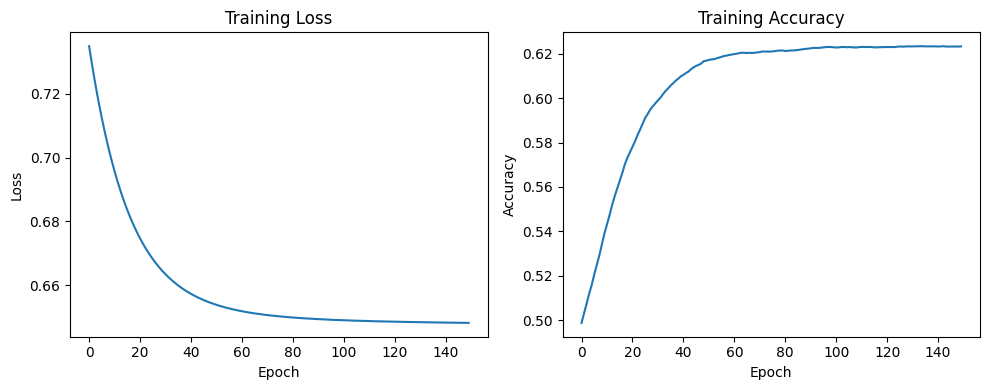

In [ ]:
# Plot the results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')



plt.tight_layout()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  pred = model(torch.from_numpy(X_test).float()).detach().numpy().squeeze() >= 0.5



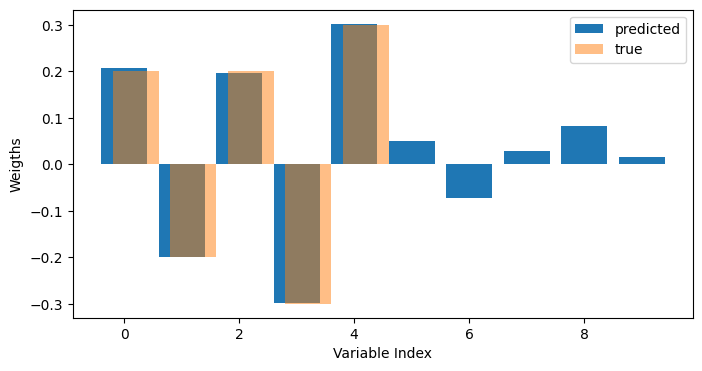

In [ ]:
pred_weights = model.linear.weight.detach().numpy().squeeze()
plt.figure(figsize=(8, 4))
plt.bar(range(10), pred_weights,label="predicted")
plt.bar(np.arange(5)+0.2, weights,alpha=0.5,label="true")
plt.xlabel("Variable Index")
plt.ylabel("Weigths")
plt.legend()

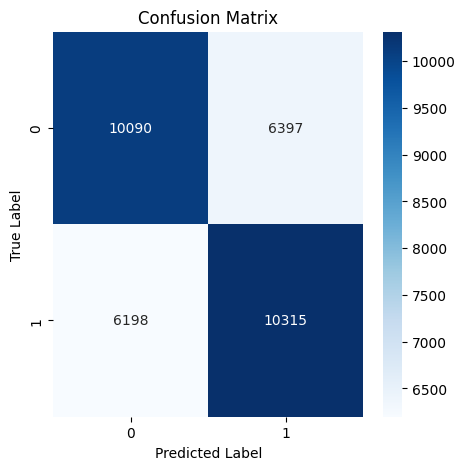

In [ ]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_test.astype("int"), pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:

def compute_integrated_gradient(batch_x, batch_blank, model):
    mean_grad = 0
    n = 64

    # WRITE MEAN GRAD OVER PATH!!!


    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients.detach().numpy()

In [ ]:
batch_x = torch.from_numpy(X_test[y_test==1][0]).float().unsqueeze(0)
batch_blank = torch.zeros_like(batch_x)

In [ ]:
batch_x.shape

torch.Size([1, 10])

In [ ]:
IGs = []
Trues = []
for i in X_test[0:256]:
  batch_x = torch.from_numpy(i).float().unsqueeze(0)
  batch_blank = torch.zeros_like(batch_x)

  IG = compute_integrated_gradient(batch_x, batch_blank, model)
  true = (batch_x - batch_blank)[0,0:5] * weights
  IGs.append(IG.squeeze())
  Trues.append(true.numpy())




In [ ]:
IGs = np.array(IGs)
Trues = np.array(Trues)
print(IGs.shape)
print(Trues.shape)

(256, 10)
(256, 5)


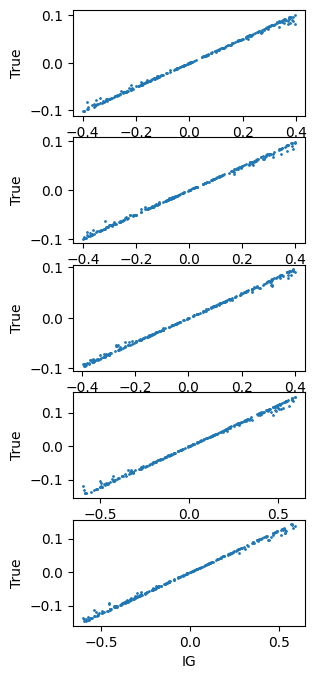

In [ ]:
f,axes = plt.subplots(5,1,figsize=(3,8))
for i in range(len(axes)):
  axes[i].scatter(Trues[:,i],IGs[:,i],s=1)
  axes[i].set_xlabel("IG")
  axes[i].set_ylabel("True")

In [ ]:
'''
a possible solution
 for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x).squeeze()
        #print(y.shape)
        (grad,) = torch.autograd.grad(y, x,is_grads_batched=False)
        mean_grad += grad / n
'''

'\na possible solution\n for i in range(1, n + 1):\n        x = batch_blank + i / n * (batch_x - batch_blank)\n        x.requires_grad = True\n        y = model(x).squeeze()\n        #print(y.shape)\n        (grad,) = torch.autograd.grad(y, x,is_grads_batched=False)\n        mean_grad += grad / n\n'